In [1]:
"""
2023 Spring 4995 Applied Computer Vision

This notebook is based on the class example
"""

'\n2023 Spring 4995 Applied Computer Vision\n\nThis notebook is based on the class example\n'

## Move to correct dic

In [ ]:
%cd /content/drive/MyDrive/DCV/bird-500-hdf5

/content/drive/MyDrive/DCV/bird-500-hdf5


In [ ]:
%cd ./drive/MyDrive/DCV

/content/drive/MyDrive/DCV


## Download dataset from Kaggle

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
api_token = {"",""} # user api token

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [ ]:
!kaggle datasets download -d gpiosenka/100-bird-species
!unzip 100-bird-species.zip

## Install dependencies

In [ ]:
!pip3 install transformers
!pip3 install evaluate

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import os
import copy
import json
import glob 
import itertools
import random
from PIL import Image
import evaluate
import h5py
from transformers.modeling_outputs import SequenceClassifierOutput

from transformers import (
    ViTImageProcessor, 
    AutoImageProcessor,
    ViTModel, 
    ResNetModel,
    TrainingArguments,
    Trainer,
)

TRAIN_DIR = "../train/"
VALID_DIR = "../valid/"
TEST_DIR = "../test/"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classes = os.listdir(TRAIN_DIR)

In [ ]:
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

## Pytorch Dataset define

In [ ]:
class BirdTrain(Dataset):
    def __init__(self, path, mode, transform=None):
        super(BirdTrain, self).__init__()
        np.random.seed(0)
        self.transform = transform
        classes = os.listdir(path)
        self.num_classes = len(classes)
        self.mode = mode

    def __len__(self):
        f = h5py.File('data.h5', 'r')
        _len = 0
        for _class in classes:
            _len += len(f[self.mode + '/' + _class])
        f.close()
        return  _len

    def __getitem__(self, index):
        label = None
        image1 = None
        image2 = None

        f = h5py.File('data.h5', 'r')

        if index % 2 == 1: # same class
            label = 1
            class1 = random.randint(0, self.num_classes - 1)
            image1 = random.choice(f[self.mode + '/' + classes[class1]])
            image2 = random.choice(f[self.mode + '/' + classes[class1]])
        
        else: # different class
            label = 0
            class1 = random.randint(0, self.num_classes - 1)
            class2 = random.randint(0, self.num_classes - 1)
            while class1 == class2:
                class2 = random.randint(0, self.num_classes - 1)
            image1 = random.choice(f[self.mode + '/' + classes[class1]])
            image2 = random.choice(f[self.mode + '/' + classes[class2]])

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        f.close()

        return {
            "image1": image1,
            "image2": image2,
            "label": label,
        }

class BirdTest(Dataset):
    def __init__(self, path, transform=None, way=500):
        np.random.seed(1)
        super(BirdTest, self).__init__()
        self.transform = transform
        self.way = way
        self.image1 = None
        self.class1 = None
        classes = os.listdir(path)
        self.num_classes = len(classes)

    def __len__(self):
        f = h5py.File('data.h5', 'r')
        _len = 0
        for _class in classes:
            _len += len(f['test/' + _class])
        f.close()
        return  _len

    def __getitem__(self, index):
        index = index % self.way

        f = h5py.File('data.h5', 'r')

        self.class1 = random.randint(0, self.num_classes - 1)
        self.image1 = random.choice(f['test/' + classes[self.class1]])

        if index == 0: # same class
            image2 = random.choice(f['test/' + classes[self.class1]])

        else: # different class
            class2 = random.randint(0, self.num_classes - 1)
            while self.class1 == class2:
                class2 = random.randint(0, self.num_classes - 1)
            image2 = random.choice(f['test/' + classes[class2]])

        if self.transform:
            image1 = self.transform(self.image1)
            image2 = self.transform(image2)
        else:
            image1 = self.image1
        
        f.close()

        return {
            "image1": image1,
            "image2": image2,
        }

## Hugging Face models define

In [ ]:
# Create a lookup table to go between label name and index
id2label = {}
label2id = {}
for idx, label in enumerate(classes):
    id2label[str(idx)] = label
    label2id[label] = str(idx)

image_preprocessor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
vit = ViTModel.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(classes),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

resnet = ResNetModel.from_pretrained("microsoft/resnet-50")
res_preprocessor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")

# freeze weights
for p in vit.parameters():
    p.requires_grad = False
for p in resnet.parameters():
    p.requires_grad = False

Some weights of the model checkpoint at microsoft/resnet-50 were not used when initializing ResNetModel: ['classifier.1.bias', 'classifier.1.weight']
- This IS expected if you are initializing ResNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ResNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
def collate_fn(batch):    
    processed_images1 = torch.squeeze(torch.from_numpy(np.array([inp["image1"] for inp in batch])))
    processed_images2 = torch.squeeze(torch.from_numpy(np.array([inp["image2"] for inp in batch])))
    labels = torch.LongTensor([inp["label"] for inp in batch])
    
    return {
        "x1": processed_images1,
        "x2": processed_images2,
        "y": labels,
    }

## Saving dataset as hdf5 files

Only need to run once

In [ ]:
import h5py

TRAIN = "train"
VALID = "valid"
TEST = "test"
paths = [TRAIN, VALID, TEST]
h = h5py.File('resdata.h5', 'w')
for path in paths:
    dset = h.create_group(path)
    for _class in classes:
        #print(f'{path}/{_class}')
        d = []
        for img in os.listdir('../' + path + '/' + _class):
            d.append(res_preprocessor(Image.open('../' + path + '/' + _class + '/' + img), return_tensors="pt")["pixel_values"].numpy())
        dset2 = dset.create_dataset(_class, data=d)
h.close()

## Load dataset

In [ ]:
train_dataset = BirdTrain('../train/', 'train')
eval_dataset = BirdTrain('../valid/', 'valid')
test_dataset = BirdTrain('../test/', 'test')

## Model define

In [2]:
class Siamese(nn.Module): #ViT
    def __init__(self, mode):
        super(Siamese, self).__init__()
        self.mode = mode
        self.ViT = vit
        self.res = resnet
        self.out = nn.Linear(self.ViT.config.hidden_size, 1)
        self.resout = nn.Linear(2048*7*7, 1)

    def forward(self, x1, x2, y=None):
        if self.mode == 'vit':
            out1 = self.ViT(x1).pooler_output
            out2 = self.ViT(x2).pooler_output
            dis = torch.abs(out1 - out2)
            out = self.out(dis)
        elif self.mode == 'res':
            out1 = self.res(x1).last_hidden_state.flatten(2)
            out2 = self.res(x2).last_hidden_state.flatten(2)
            dis = torch.abs(out1 - out2)
            out = self.resout(dis)
        logits = torch.sigmoid(out)

        loss = None
        if y is not None:
            loss_fct = torch.nn.BCEWithLogitsLoss(size_average=True)
            loss = loss_fct(out.view(-1), y.view(-1).float())

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
        )

NameError: ignored

In [ ]:
net = Siamese('vit')
net = net.to(device)
#print(net)

In [ ]:
output_dir = './ViT-siamese-2-10'

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    lr_scheduler_type="cosine",
    logging_steps=10,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    #load_best_model_at_end=True,
    dataloader_num_workers=0,  
    gradient_accumulation_steps=4,
)

In [ ]:
# Compute absolute learning rate
base_learning_rate = 1e-3
total_train_batch_size = (
    training_args.train_batch_size * training_args.gradient_accumulation_steps * training_args.world_size
)

training_args.learning_rate = base_learning_rate * total_train_batch_size / 256
print("Set learning rate to:", training_args.learning_rate)

Set learning rate to: 0.000125


In [ ]:
# Setup a function to compute accuracy metrics
metric = evaluate.load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=p.predictions, references=p.label)

In [ ]:
# Create the trainer
trainer = Trainer(
    model=net,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

## Train

In [ ]:
# Train
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 80085
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 25020
  Number of trainable parameters = 769
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch,Training Loss,Validation Loss
0,0.556600,No log
1,0.488500,No log
2,0.470100,No log
3,0.405000,No log
4,0.408300,No log
5,0.388000,No log
6,0.367400,No log
7,0.357200,No log
8,0.395500,No log
9,0.386100,No log


***** Running Evaluation *****
  Num examples = 2500
  Batch size = 32
Saving model checkpoint to ./ViT-siamese-2-10/checkpoint-2502
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
***** Running Evaluation *****
  Num examples = 2500
  Batch size = 32
Saving model checkpoint to ./ViT-siamese-2-10/checkpoint-5004
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
***** Running Evaluation *****
  Num examples = 2500
  Batch size = 32
Saving model checkpoint to ./ViT-siamese-2-10/checkpoint-7506
Trainer.model is not a `PreTrainedModel`, only saving its

***** train metrics *****
  epoch                    =       10.0
  total_flos               =        0GF
  train_loss               =     0.4357
  train_runtime            = 2:22:14.53
  train_samples_per_second =     93.836
  train_steps_per_second   =      2.932


In [ ]:
# Evaluate on the test dataset
metrics = trainer.evaluate(test_dataset)
trainer.log_metrics("test", metrics)

***** Running Evaluation *****
  Num examples = 2500
  Batch size = 32
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


***** test metrics *****
  epoch                   =       10.0
  eval_runtime            = 0:00:29.26
  eval_samples_per_second =     85.439
  eval_steps_per_second   =        2.7


In [ ]:
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=32,
    shuffle=True, 
    num_workers=0, 
    collate_fn=collate_fn,
)

## Load model (bin file)

The metric wasn't working as expected

In [ ]:
loadmodel = Siamese()
loadmodel.load_state_dict(torch.load('./ViT-siamese-2-10/pytorch_model.bin')) # it takes the loaded dictionary, not the path file itself
loadmodel.eval()
loadmodel.cuda()

## Accuracy calculation

In [ ]:
sum = 0
err = 0
for batch in test_dataloader:
    print(sum)
    sum += batch["x1"].shape[0]
    p = loadmodel(batch["x1"].cuda(), batch["x2"].cuda())
    pre = p["logits"].to("cpu").squeeze().detach().numpy()
    y = np.array(batch["y"])
    id = 0
    for i in pre:
        if i > 0.5:
            pre[id] = 1
        else:
            pre[id] = 0
        id += 1
    err += np.sum(abs(pre - y))

print('accuray: ', (sum - err)/sum)

0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
896
928
960
992
1024
1056
1088
1120
1152
1184
1216
1248
1280
1312
1344
1376
1408
1440
1472
1504
1536
1568
1600
1632
1664
1696
1728
1760
1792
1824
1856
1888
1920
1952
1984
2016
2048
2080
2112
2144
2176
2208
2240
2272
2304
2336
2368
2400
2432
2464
2496
accuray:  0.9328


## Plot

In [ ]:
import json

log = None
with open('./ViT-siamese-2-10/trainer_state.json', 'r') as j:
     log = json.loads(j.read())
log = log["log_history"]
steps = []
loss = []
lr = []
for item in log:
    if "loss" in item:
        steps.append(item["epoch"])
        loss.append(item["loss"])
        lr.append(item["learning_rate"])

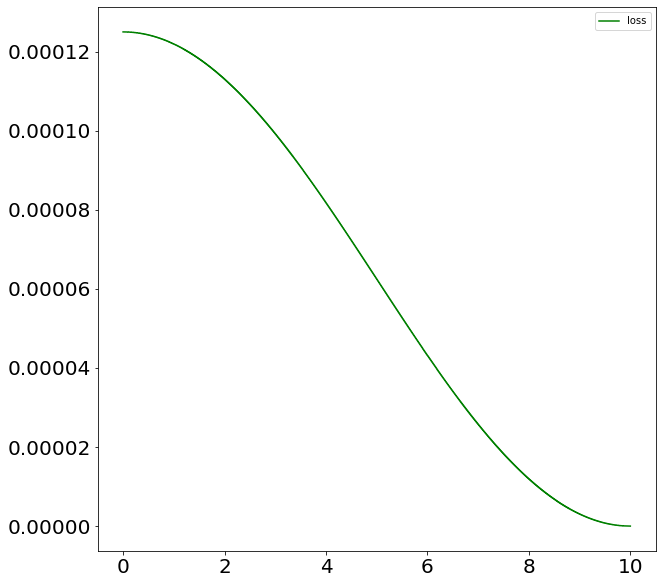

In [ ]:
import matplotlib.pyplot as plt


f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(prop={'size': 20})
plt.plot(steps, lr, linestyle='-', color='g', label="loss")
plt.legend()